In [1]:
# Import modules 
import pymaster as nmt
#import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline

#We are going to generate flatmaps using the Flatmap class
# Q: where do I get the flatmaps module?
#https://github.com/LSSTDESC/NaMaster/blob/master/sandbox_validation/data/flatmaps.py -SAU
# Nord: I ran the conda install procedure, but flatmaps still does not imprt. 
#You got this work after I commited flatmaps.py to the repo, right?
import flatmaps as fm
from astropy.wcs import WCS

# To generate maps in flat-sky approximation we need NaMaster (pymaster)
# To install pymaster -> conda install namaster -c conda-forge

In [64]:
def plot_fourier_1d(output_names, spectra, lmax, dx, nx, bin_factor = 1.):
        lmaxplot = lmax/np.sqrt(2)
        tfac = dx/nx
        binsize = bin_factor * np.sqrt(2)*np.pi/(dx*nx)
        lbins = np.arange(binsize, lmaxplot, binsize)
        cbins = 0.5*(lbins[0:-1] + lbins[1:])
        lx, ly = np.meshgrid(np.linspace(-lmax+lstep, lmax, nx),
                             np.linspace(-lmax+lstep, lmax, nx))
        ell = np.sqrt(lx**2 + ly**2)
        norm, bins = np.histogram(ell, bins=lbins)
        norm = norm.astype(float)
        norm[ np.where(norm != 0.0) ] = 1./norm[ np.where(norm != 0.0) ]
        
        # Scaling of spectra for plotting:
        # We usually plot 1e7 * [L(L+1)]^2 / (2*pi) * Cl_phi_phi.
        # Scaling for the power spectrum of a phi map:
        tpp = lambda l : (l*(l+1.))**2 / (2.*np.pi) * 1e7
        
        # Scaling for the power spectrum of a kappa map:
        # kappa_n = -1/2 \grad^2 phi_n
        # Therefore, the power spectra are related as:
        # 4/(2*pi) Clkk = [L(L+1)]^2 / (2*pi) * Clpp
        tkk = lambda l: 4/(2*np.pi) * 1e7
        
        # Usual CMB scaling for the EE spectrum
        tee = lambda l: l*(l+1) / (2*np.pi)
        
        for spectra, name in zip(spectra, output_names):
            spec = _unwrap_fourier_2d(spectra[0]*tfac**2)
            cl_true, bins = np.histogram(ell, bins=lbins,
                                         weights=spec)
            cl_true *= norm
            spec = _unwrap_fourier_2d(spectra[1]*tfac**2)
            cl_pred, bins = np.histogram(ell, bins=lbins,
                                         weights=spec)
            cl_pred *= norm
            spec = _unwrap_fourier_2d(spectra[2]*tfac**2)
            cl_cros, bins = np.histogram(ell, bins=lbins,
                                         weights=spec)
            cl_cros *= norm
            spec = _unwrap_fourier_2d(spectra[3])
            cl_miss, bins = np.histogram(ell, bins=lbins,
                                         weights=spec)
            cl_miss *= norm
            plt.figure()
            plt.xlabel('$L$')
            if name == 'E':
                plt.ylabel('$(L(L+1))/(2\pi) C_L^{EE}$')
                factor = tee(cbins)
            elif name == 'kappa':
                plt.ylabel('$10^7/(2\pi) C_L^{\kappa\kappa}$')
                factor = tkk(cbins)
            elif name == 'phi':
                plt.ylabel('$10^7/(2\pi) L^2(L+1)^2 C_L^{\phi\phi}$')
                factor = tpp(cbins)
            else:
                plt.ylabel('$C_L^{%s%s}$'%(name, name))
                factor = np.ones(len(cbins))
            plt.title('%s Power spectrum'%name)
            plt.xlim([0, lmaxplot-binsize])
            plt.yscale('log')
            plt.plot(cbins, factor * cl_true, c = black, label='True spectrum')
            plt.plot(cbins, factor * cl_pred, c = blue, label='Predicted spectrum')
            plt.plot(cbins, factor * cl_cros, c = orange, label='Cross spectrum')
            plt.legend()
            plt.savefig('/spectra_%s_1d.png' % name)
            plt.show()
            plt.clf()

In [65]:
def _compute_fourier_spectra(dx, nx, lmax):
        lmax = np.pi/dx
        lstem = lmax*2/nx
        spectra = []
        spectra_types = ['True', 'Predicted', 'Cross', 'Missing']
        for y_pred, y_true in zip(self.phys_y_pred, self.phys_y_true):
            true_fft = np.fft.rfft2(y_true)
            pred_fft = np.fft.rfft2(y_pred)
            diff_fft = np.fft.rfft2(y_true - y_pred)
            true_fft_sq = true_fft * np.conj(true_fft)
            pred_fft_sq = pred_fft * np.conj(pred_fft)
            cross_fft = pred_fft * np.conj(true_fft)
            diff_fft_sq = diff_fft * np.conj(diff_fft)
            true_av_fft = np.average(true_fft_sq, axis = (0,1))
            pred_av_fft = np.average(pred_fft_sq, axis = (0,1))
            cross_av_fft = np.average(cross_fft, axis = (0,1))
            missing_fft = np.average(diff_fft_sq, axis = (0,1))/true_av_fft
            self.spectra.append([true_av_fft, pred_av_fft, cross_av_fft,
                                 missing_fft])

In [66]:
def _unwrap_fourier_2d(spectrum, nx):
        unwrapped = np.zeros((nx,nx))
        halfpix = nx//2
        spectrum_r = np.real(spectrum)
        spectrum_inv = np.concatenate((spectrum_r[(halfpix+1):], spectrum_r[:(halfpix+1)]))
        unwrapped[:, (halfpix - 1):] = spectrum_inv
        unwrapped[-1, :(halfpix - 1)] = spectrum_inv[-1, 1:halfpix][::-1]
        unwrapped[:-1, :(halfpix - 1)] = spectrum_inv[:-1, 1:halfpix][::-1,::-1]
        return unwrapped

In [2]:
# Q: where did this file come from?
# From CAMB (well from Kimmy, who generated it with CAMB), https://camb.info/readme.html -SAU

#You got this off of GitHub, right?
#I think this is the link but I can't check because this coffee shop WiFi won't let me go on GitHub:
#https://github.com/cmbant/CAMB
#-SAU

# Q: what are each of the outputs?
#    l modes, TT spectrum, EE spectrum, TE spectrum, Phi-Phi spectrup, Phi-T spectrum -SAU

# Q: What is "P?"
#    Phi? -SAU
# Nord: why are you unsure about this?
#    Because I'm not exactly sure which P you're referring to, but I THINK you're referring to the P in clPP
# Nord 2020/01/13: Are there other P's?
#    Yeah, in the filename there's a lot of mumbo-jumbo like "plikHM" and I'm not sure if the "P" is part of an abbreviation or if it's random variable names or what

# Nord 2020/01/13: where can get this data?
l, clTTa, clEEa, clTEa, clPPa, clPTa = np.loadtxt("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", unpack=True)

In [55]:
# Generate an artificial power-spectrum (you can use a "realistic" power-spectrum from CAMB or CLASS)
# ells_input = np.arange(1,10000) # We generate 10,000 multipoles
clTT = clTTa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clEE = clEEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clTE = clTEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clPP = clPPa / (l**4 * (2.726 * 1e6)**2) # Simple power-law power-spectrum, @vis: creates the 1D spectrum to draw from
clPT = clPTa / (l**4) # Simple power-law power-spectrum
cl_input = [clTT, clEE, clTE, clPP, clPT]
clPP[0] = 0 #Testing setting the 0-mode to 0 to change the overall strength of the map

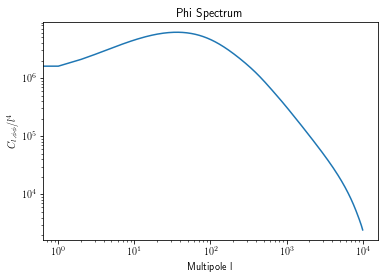

In [56]:
# Nord: what are the units on these axes? 
#X-axis is l, Y-axis I don't think has units?
#Because CAMB says the units are microK^2, and then we divide out by microK^2 when normalizing


plt.rc('text', usetex = True)
plt.plot(clPPa)
plt.title("Phi Spectrum")
plt.xlabel("Multipole l")
plt.ylabel("$C_{l, \phi \phi}/l^4$")
plt.xscale("log")
plt.yscale("log")

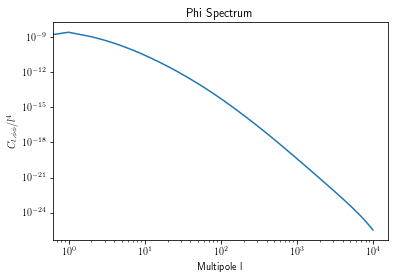

In [57]:
# Nord: what are the units on these axes? 
#X-axis is l, Y-axis I don't think has units?
#Because CAMB says the units are microK^2, and then we divide out by microK^2 when normalizing


plt.rc('text', usetex = True)
plt.plot(clPP)
plt.title("Phi Spectrum")
plt.xlabel("Multipole l")
plt.ylabel("$C_{l, \phi \phi}/l^4$")
plt.xscale("log")
plt.yscale("log")

In [58]:
# Create the empty map object with the resolution that we want
# Set parameters for empy map with resolution

pixels = 192.
side = 5 #5 degrees
reso = side/pixels 

# Generate the WCS (world coordinate system) for the flatmap
w = WCS(naxis=2)
nx = int(pixels) #Number of pixels in the x axis
ny = int(pixels) #Number of pixels in the y axis
# Q: should this be equal to pixels?
# SAU: yes, fixed

# 
w.wcs.crpix = [nx/2, ny/2] # Center pixel X, Y
w.wcs.cdelt = np.array([-reso, reso])
w.wcs.crval = [0, 0] # Center coordinates RA, DEC at 0,0
w.wcs.ctype = ["RA---AIR", "DEC--AIR"] # Airy projection



In [59]:
nx
# Nord 2020/01/13: why is nx = 192, if pixels= 128 above?
# Because I hadn't rerun it since making the change -SAU

192

In [60]:
# This is the map object that will be used to generate the fake CMB maps
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=side, ly=side) 

In [61]:
# Q: What is the math related to this?
#SAU: I don't know, I can look into it though
phi_map = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = 0)

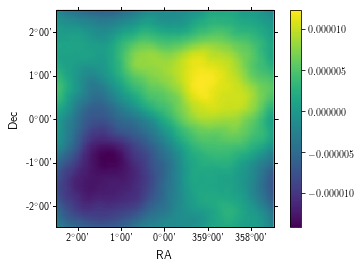

In [62]:
fmi.view_map(phi_map[0].flatten()) 

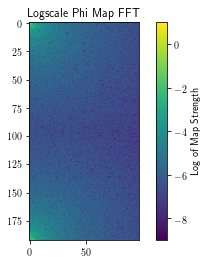

In [63]:
phi_map_fft = np.fft.rfft2(phi_map[0])

minimum = np.amin(abs(phi_map_fft))
maximum = np.amax(abs(phi_map_fft))

plt.imshow(np.log10(np.abs(phi_map_fft)), vmin=-9, vmax=1)
plt.colorbar(label="Log of Map Strength")
plt.title("Logscale Phi Map FFT")

np.save("phi_map_fft_0-mode", phi_map_fft)

In [12]:
np.amax(abs(phi_map_fft))

0.09608387162177519

In [13]:
# Q: What is the difference between this data and the data in the previous cell?
#SAU: This is the data after it's been loaded into the QuickLens structure.
#This was in order to debug to figure out why the phi map looked stronger after going into the quicklens data structure
#Apparently when the phi map is loaded into the QuickLens data structure, it gets multiplied by a scale factor
#I couldn't find any documentation explaining why.
phi_map_ql = np.load("phi_map_ql_structure.npy")

In [14]:
phi_map_fft_ql = np.load("phi_map_fft_ql_structure.npy")

In [15]:
num_maps = 11200
i=0
all_maps = np.zeros([num_maps,int(pixels),int(pixels)])
while i < num_maps:
    map_gen = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = i)
    all_maps[i] = map_gen
    if np.mod(i,100) == 0:
        print i,
    i+=1

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100


In [16]:
np.save("./all_phi_map_fft", all_maps)

In [17]:
np.shape(all_maps)

(11200, 192, 192)